<a href="https://colab.research.google.com/github/EZ-maas/PRA3024_Zavialova/blob/main/EZ_ML_cifar_CNN_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Elizaveta Zavialova (i6213355)**

**PRA3024, Assignment 3 - Convolutional Neural Networks**

Disclaimer: Final structure of the NN is heavily based on the following article (https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/).

Prior to finding it i used several different approaches, including trying kernels of different sizes to locate patterns of different sizes and using multitude of dense layers. I figured out how to prevent overfitting, but maximum accuracy that i achieved before applying the structure of multiple layers with identical kernels was 77%. I commented out some of my previous attempts to demonstrate what i have tried prior to finding out about this structure.


In [1]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')
    
    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)
    
        

    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)
    

def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):
    
    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]
    
    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)
    
    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')
    
    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])

    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [2]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.3


In [3]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...
Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


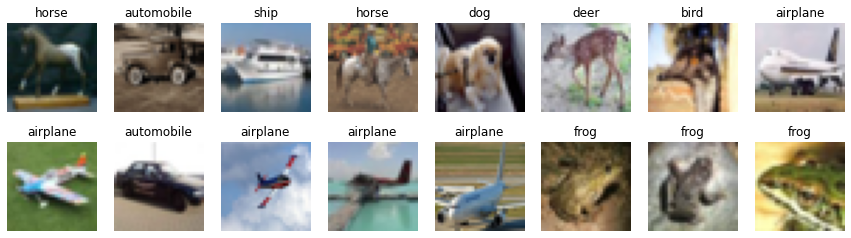

In [4]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [5]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

#The overall approach to the model:
 - I prioritized accuracy over speed, so CNN initially had shallow structure with three conv2d+pooling layers and 4 dense layers

  - Several CNN blocks were used 3 by 3 for a low - dimensional patterns and 7 by 7 for larger patterns (made by combining three  3 by 3 kernels)
  - I tried out several training options (using 1*1 kernel to reduce dimensionality, replacing big kernels with several layers with 3 by 3 kernels, adding gaussian noise to further reduce overfitting, etc.) but mostly they didn't improve accuracy and increased time, most likely they are meant to be used on bigger models or i just implemented them incorrectly

 - For the preprocessing of data i used data augmentation (horizontal flip and zooming and height-width shifting)
 - Using more parameters for augmentation proved to increase training time too much
 - Additionally, regularization and dropout layers are meant to prevent overfitting 
 - The final version of the model takes about 35 epochs to be trained to 85% accuracy(claimed max accuracy ~96% with over 100 epochs)




In [6]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, GaussianNoise, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator

In [14]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """

    model = Sequential()

    ### STUDENT CODE HERE ###
 
   # Conv2D (n-filters, size of kernel, activation, padding, input shape)

  


    weight_decay = 1e-4 
    model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'Same', input_shape =  (32, 32, 3), kernel_regularizer=regularizers.l2(weight_decay)))  # low-dim patterns investigated by 3*3 kernel
    model.add(BatchNormalization())                                                                                                                                            # batch normalization is meant to reduce training time (https://arxiv.org/abs/1502.03167) 
    model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'Same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())                                                                                          
    model.add(MaxPooling2D(pool_size = (2,2), strides = 2))
    # Dropout(0<rate<1)
    model.add(Dropout(.2))


    model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'Same', kernel_regularizer=regularizers.l2(weight_decay))) 
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'Same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), strides = 2))
    model.add(Dropout(.3))


    model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'Same', kernel_regularizer=regularizers.l2(weight_decay))) 
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'Same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), strides = 2))
    model.add(Dropout(.4))
    
    model.add(Flatten())

    model.add(Dense(10, activation = 'relu'))

    # Ensure normalized probabilities over the 10 classes
    model.add(Activation("softmax")) 

    return model


    #---------------------------------------------------------------------------------------------------------------------
    #                              FAILED STRATEGIES
    # -snippets of code that i have used before finding out about the 'non-shallow' cnn architecture

    # 1*1 kernel can be used for dimesionality reduction (https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/lecture-02-cnns.pdf)
    # model.add(Conv2D(filters = 64, kernel_size = (1,1), activation = 'relu', padding = 'Same',  input_shape =  (32, 32, 3))) 

    # analog of 7*7 kernel for a bigger dimensional patterns
    #model.add(Conv2D(filters = 10, kernel_size = (1,1), activation = 'relu', padding = 'Same')) 
    #model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'Same'))  
    #model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'Same'))
    #model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'Same')) 

    #model.add(Conv2D(filters = 64, kernel_size = (5,5), activation = 'relu', padding = 'Same'))


    
    #model.add(GaussianNoise(0.5)) 
    #model.add(Dense(256, activation = 'relu'))
    #model.add(Dense(32, activation = 'relu'))
    #model.add(Dense(32, activation = 'relu'))
    #model.add(Dense(10, activation = 'relu'))

    #---------------------------------------------------------------------------------------------------------------------
   

    
  

 
    

    ### END STUDENT CODE ### 

  

In [18]:

#   ****** DATA AUGMENTATION ******

# to get a bigger training dataset and prevent overfitting
# source of inspiration: https://www.youtube.com/watch?v=14syUbL16k4&ab_channel=deeplizard

#Image preprocessing function that describes all types of chnges made to the images
gen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
   # shear_range=0.15,
    zoom_range=0.1,
    #channel_shift_range=5.,
    horizontal_flip=True,
)

In [19]:
### STUDENT CODE HERE ###
### --> change the parameters below to perform a better training

INIT_LR = 0.001  # initial learning rate
BATCH_SIZE = 64
EPOCHS = 45


K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [20]:
# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(lr=INIT_LR),  # for SGD.
    metrics=['accuracy']  # report accuracy during training
)

gen.fit(x_train)
# fits the model on batches with real-time data augmentation:

# fit model
model.fit(
    gen.flow(x_train, y_train,  # augmented data
    batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
)

# save weights to file to avoid re-training
model.save_weights("weights.h5")

Epoch 1/45
625/625 [==============================] - 23s 36ms/step - loss: 2.3552 - accuracy: 0.1371 - val_loss: 2.2062 - val_accuracy: 0.2656
Epoch 2/45
625/625 [==============================] - 22s 35ms/step - loss: 2.1667 - accuracy: 0.2512 - val_loss: 2.0693 - val_accuracy: 0.3707
Epoch 3/45
625/625 [==============================] - 22s 34ms/step - loss: 1.7395 - accuracy: 0.4271 - val_loss: 1.3124 - val_accuracy: 0.5495
Epoch 4/45
625/625 [==============================] - 21s 34ms/step - loss: 1.3558 - accuracy: 0.5397 - val_loss: 1.2714 - val_accuracy: 0.5796
Epoch 5/45
625/625 [==============================] - 21s 34ms/step - loss: 1.2086 - accuracy: 0.5922 - val_loss: 1.1089 - val_accuracy: 0.6366
Epoch 6/45
625/625 [==============================] - 21s 34ms/step - loss: 1.1141 - accuracy: 0.6250 - val_loss: 0.9831 - val_accuracy: 0.6783
Epoch 7/45
625/625 [==============================] - 21s 34ms/step - loss: 1.0283 - accuracy: 0.6537 - val_loss: 0.9687 - val_accuracy:

In [21]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


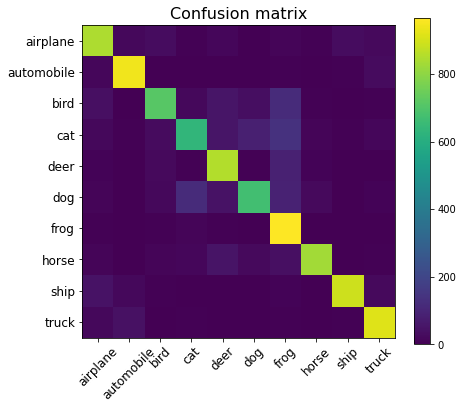

Test accuracy: 0.8274


In [22]:
# make test predictions
y_pred_test = model.predict_proba(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

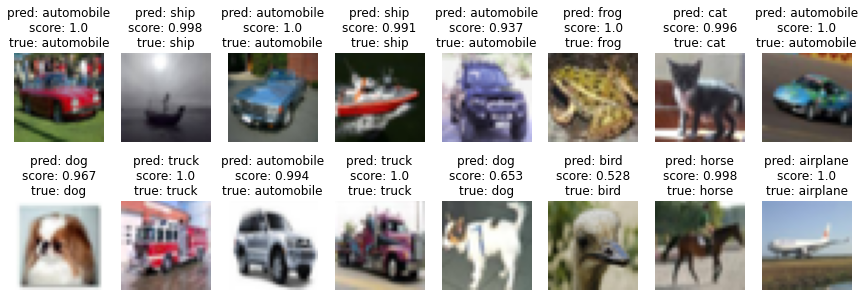

In [23]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons, 
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.


